In [1]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [2]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
import math

warnings.filterwarnings("ignore")

%matplotlib inline
mpld3.enable_notebook()

In [4]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

c5 c6 c7 c8 c9        n0        n1        n2        n3        n4 class
0  a  a  b  a  a  0.448573  1.212644  2.555515  0.242702  0.697604     A
1  a  a  a  b  b  1.902515 -0.467349 -0.744523 -0.017156 -0.380288     A
2  a  a  a  b  b  0.825045  1.002267  1.972207 -0.790095  0.233456     B
3  a  a  a  b  b -0.124974  0.902601  1.696092 -0.320182  0.243261     A
4  b  a  a  b  a -1.259765  0.793134  1.547527 -2.132172 -0.788367     B

In [5]:
# cfpdss data with missing values
df_cfpdss_missing = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss_m0.5.csv"
)
df_cfpdss_missing = df_cfpdss_missing.iloc[:, 1:]
df_cfpdss_missing.head()

c5 c6 c7 c8 c9        n0        n1        n2        n3        n4  class
0  a  a  b  a  a  0.448573  1.212644  2.555515  0.242702  0.697604      0
1  a  a  a  b  b  1.902515 -0.467349 -0.744523 -0.017156 -0.380288      0
2  a  a  a  b  b  0.825045  1.002267  1.972207 -0.790095  0.233456      1
3  a  a  a  b  b -0.124974  0.902601  1.696092 -0.320182  0.243261      0
4  b  a  a  b  a -1.259765  0.793134  1.547527 -2.132172 -0.788367      1

In [6]:
# ------ Data pre-processing --------------
def data_encoding(data, feature_scaling=True):
    X_df = data.drop(columns="class")

    # Separating categorical and non-categorical columns
    categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
    X_df_categorical = X_df[categorical_columns]
    non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
    X_df_non_categorical = X_df[non_cat_columns]

    # One hot encoding - Categorical data
    encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    one_hot_encoded = encoder.fit_transform(X_df_categorical)
    columns = encoder.get_feature_names_out()
    X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

    # Feature scaling numerical data/non-categorical data
    if feature_scaling:
        scaler = MinMaxScaler()
        X_df_non_categorical = pd.DataFrame(
            scaler.fit_transform(X_df_non_categorical),
            columns=scaler.get_feature_names_out(),
        )

    # Concatenate categorical and non-categorical data
    X_df_encoded = pd.concat(
        [
            X_df_cat_one_hot,
            X_df_non_categorical,
        ],
        axis=1,
    )

    # Encoding the target variable
    y_df = df_cfpdss[["class"]]
    y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    y_one_hot = y_encoder.fit_transform(y_df)
    y_encoded = pd.Series(y_one_hot.ravel())

    return X_df_encoded, y_encoded

In [7]:
X_df_encoded, y_encoded = data_encoding(df_cfpdss)
X_df_encoded_m, y_encoded_m = data_encoding(df_cfpdss_missing)

In [8]:
from MDDM import MDDM_A

no of concept drifts 6
Time points for warning levels [1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 7840, 7847, 7848, 7849, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 786

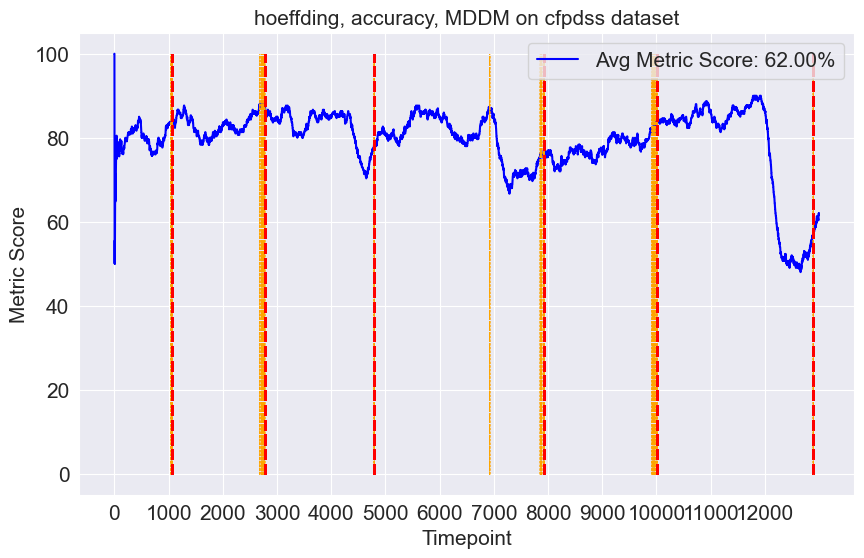

In [29]:
def detect_concept_drift_using_MDDM(model, X_df, y_df, metric_func, window_size=100):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    warnings_level_timepoints = []
    my_model = model

    window_y = deque(maxlen=window_size)
    MDDM_A_drift_detector = MDDM_A(
        sliding_win_size=window_size, confidence=0.001, warning_confidence=0.005
    )

    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        windowed_metric_val = (
            metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100
        )

        metric_score_list.append(windowed_metric_val)

        MDDM_A_drift_detector.input(int(y_pred == yi))

        if MDDM_A_drift_detector.is_warning_zone:
            warnings_level_timepoints.append(timepoint)
        if MDDM_A_drift_detector.is_change_detected:
            concept_drifts_timepoints.append(timepoint)
            my_model = my_model.clone()

        timepoint += 1
    print(f"no of concept drifts {len(concept_drifts_timepoints)}")
    print(f"Time points for warning levels {warnings_level_timepoints}")
    print(f"Time points for concept drift {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list, warnings_level_timepoints


concept_drift_timepoints, metric_score_list, warning_level_timepoints = (
    detect_concept_drift_using_MDDM(
        HoeffdingTreeClassifier(),
        X_df_encoded,
        y_encoded,
        accuracy_score,
        window_size=300,
    )
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    warning_level_timepoints,
    "hoeffding" + ", " + "accuracy" + ", " + "MDDM",
)

In [10]:
concept_drift_timepoints, metric_score_list, warning_level_timepoints = (
    detect_concept_drift_using_MDDM(
        HoeffdingTreeClassifier(),
        X_df_encoded,
        y_encoded,
        accuracy_score,
        window_size=300,
    )
)

no of concept drifts 5
Time points for warning levels [1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1099, 1100, 1141, 1142, 1143, 1144, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 2033, 2037, 2611, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2716, 2717, 2718, 2719, 2724, 2725, 2726, 2727, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 282

In [28]:
# ------ Function to plot concept drift -------------
def plot_concept_drift(
    concept_drifts_timepoints,
    metric_score_list,
    warning_lvl_timepoints,
    name: "Model Name + Drift Detector + Metric" = "None",
):
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(
        list(range(len(metric_score_list))),
        metric_score_list,
        "-b",
        label="Avg Metric Score: %.2f%%" % (metric_score_list[-1]),
    )

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Timepoint")
    plt.ylabel("Metric Score")
    plt.xticks(np.arange(0, 13000, 1000))

    # Plot warning levels with vertical lines of different color than drifts
    for i in range(len(warning_level_timepoints)):
        # plt.text(self.concept_drifts_timepoints[i] - 500, 100.8, 'Drift ' + str(i), c="red", fontsize=25)
        plt.vlines(
            warning_level_timepoints[i],
            0,
            100,
            colors="orange",
            linewidth=0.5,
            linestyles="dashed",
        )

        # Plot concept drift with vertical lines
        for i in range(len(concept_drifts_timepoints)):
            # plt.text(self.concept_drifts_timepoints[i] - 500, 100.8, 'Drift ' + str(i), c="red", fontsize=25)
            plt.vlines(
                concept_drifts_timepoints[i],
                0,
                100,
                colors="red",
                linewidth=2,
                linestyles="dashed",
            )
    mplcursors.cursor(hover=True)

    plt.show()

no of concept drifts 5
Time points for warning levels [1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1099, 1100, 1141, 1142, 1143, 1144, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 2033, 2037, 2611, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2716, 2717, 2718, 2719, 2724, 2725, 2726, 2727, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 282

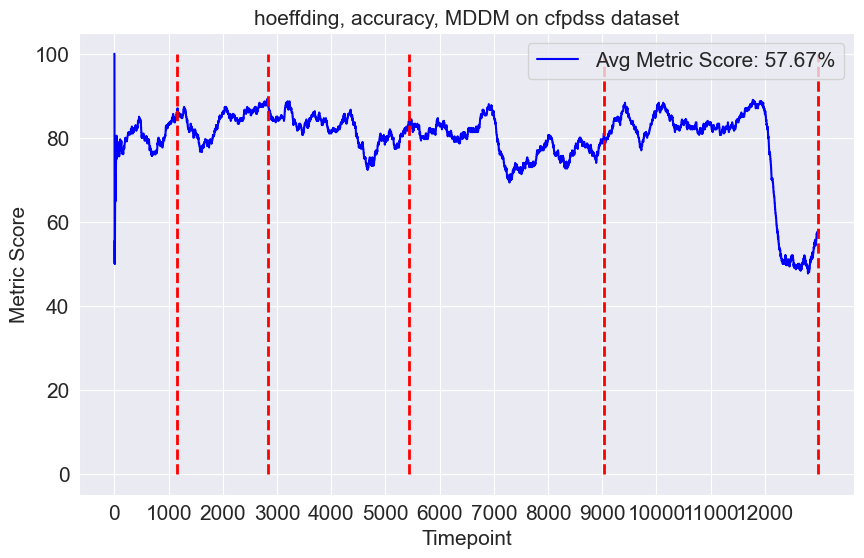

In [12]:
concept_drift_timepoints, metric_score_list, warning_level_timepoints = (
    detect_concept_drift_using_MDDM(
        HoeffdingTreeClassifier(),
        X_df_encoded,
        y_encoded,
        accuracy_score,
        window_size=300,
    )
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    warning_level_timepoints,
    "hoeffding" + ", " + "accuracy" + ", " + "MDDM",
)

In [13]:
concept_drift_timepoints, metric_score_list = detect_concept_drift_using_MDDM(
    HoeffdingTreeClassifier(), X_df_encoded, y_encoded, accuracy_score, window_size=300
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    "hoeffding" + ", " + "accuracy" + ", " + "MDDM",
)

no of concept drifts 5
Time points for warning levels [1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1099, 1100, 1141, 1142, 1143, 1144, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 2033, 2037, 2611, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2716, 2717, 2718, 2719, 2724, 2725, 2726, 2727, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 282

ValueError: too many values to unpack (expected 2)

In [20]:
def detect_concept_drift_using_FHDDM(model, X_df, y_df, metric_func, window_size=100):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model

    window_y = deque(maxlen=window_size)
    drift_detector = FHDDM(sliding_window_size=window_size, confidence_level=0.001)

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        windowed_metric_val = (
            metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100
        )

        metric_score_list.append(windowed_metric_val)

        drift_detector.update(int(not (y_pred == yi)))
        if drift_detector.drift_detected:
            concept_drifts_timepoints.append(timepoint)
            my_model = my_model.clone()

        # Update the window with new prediction and get the current metric value of the window
        # window_y.append((yi, y_pred))
        # y_i_list, y_pred_list = zip(*window_y)
        # windowed_metric_val = metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100

        # Recalculate the metric using only the values within the window
        # if len(window_y) == window_size:

        #     my_drift_detector.update(windowed_metric_val)

        #     if my_drift_detector.drift_detected:
        #         concept_drifts_timepoints.append(timepoint)
        #         my_model = my_model.clone()  # Clone the model upon drift detection
        #         window_y.clear()  # Clear window on drift detection

        # metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"no of concept drifts {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list

no of concept drifts 6
Time points for concept drift [1160, 2663, 4847, 7938, 9995, 12948]


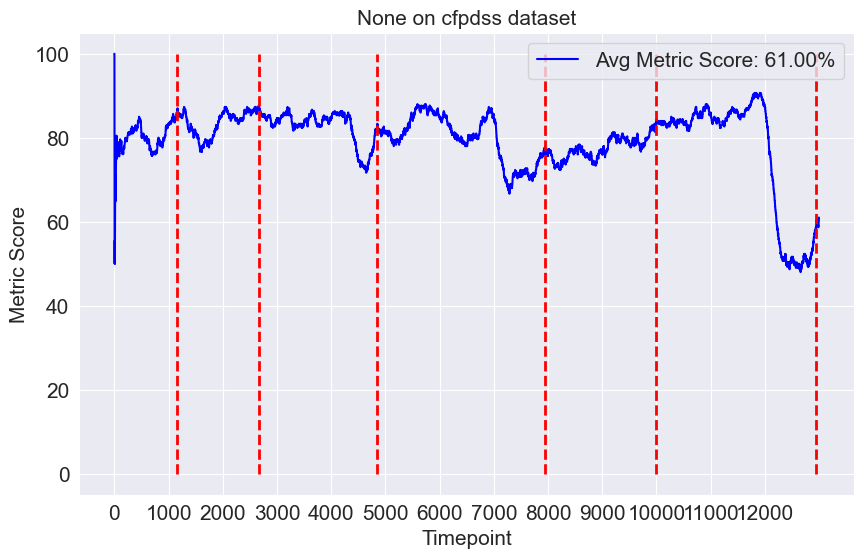

In [21]:
concept_drift_timepoints, metric_score_list = detect_concept_drift_using_FHDDM(
    HoeffdingTreeClassifier(), X_df_encoded, y_encoded, accuracy_score, window_size=300
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    "hoeffding" + ", " + "accuracy" + ", " + "FHDDM",
)

In [18]:
%run MDDM.py

epsilon for delta : 0.21856023572670366, epsilon for warning delta : 0.1985481706927976
